# Analysis Code for 2-Point Correlator

## Preparation

In [ ]:
%pip install numpy scipy iminuit matplotlib scienceplots

In [1]:
import os
import numpy as np
from iminuit import Minuit
from iminuit.cost import LeastSquares
import matplotlib.pyplot as plt
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("retina")
from matplotlib import ticker
import scienceplots

plt.style.use(["science", "nature"])
# plt.style.use(["default"])
plt.rcParams.update(
    {
        "font.size": 12,  # 全局字体大小
        "axes.titlesize": 12,  # 子图标题的字体大小
        "axes.labelsize": 12,  # 轴标签的字体大小
        "xtick.labelsize": 12,  # x轴刻度标签的字体大小
        "ytick.labelsize": 12,  # y轴刻度标签的字体大小
        "legend.fontsize": 12,  # 图例的字体大小
        "figure.titlesize": 12,  # 图标题的字体大小
    }
)

In [2]:
t_size = 64
a = 0.090713
a_invrs = 2.1753
bin_count = 18

droot = "/Volumes/X6/data/ccbar"

gfix = ["gfix_C", "gfix_L"]
gauge = ["Coulomb", "Landau"]
channel = ["ps", "v", "s", "av", "t"]
binID = ["BIN" + f"{i:02}" for i in range(1, 1 + bin_count)]

## 2pt-standard-analysis

In [3]:
for ig in range(2):
    bin_path = f"{droot}/{gfix[ig]}/2pt/binned"
    trev_path = f"{droot}/{gfix[ig]}/2pt/trev"
    jksamp_path = f"{droot}/{gfix[ig]}/2pt/jksamp"
    effmass_path = f"{droot}/{gfix[ig]}/2pt/effmass"

    corr_result_path = f"result/{gauge[ig]}/corr-2pt"
    effmass_result_path = f"result/{gauge[ig]}/effmass"

    os.system(
        f"rm -rf {trev_path} {jksamp_path} {effmass_path} {corr_result_path} {effmass_result_path}"
    )  # clear data
    os.makedirs(trev_path, exist_ok=True)  # make directory for trev files
    os.makedirs(jksamp_path, exist_ok=True)  # make directory for jksamp files
    os.makedirs(effmass_path, exist_ok=True)  # make directory for effmass files
    os.makedirs(corr_result_path, exist_ok=True)  # make directory for result files
    os.makedirs(effmass_result_path, exist_ok=True)  # make directory for result files

    os.system(f"bin/trev2 -n {t_size} -d {trev_path} {bin_path}/2pt.*")

    for ichan in channel:
        # Corr
        os.system(f"bin/jre -l {t_size} -d {jksamp_path} -v {trev_path}/2pt.{ichan}.*")
        os.system(
            f"bin/mean -l {t_size} -o {corr_result_path}/{ichan} -jc {jksamp_path}/2pt.{ichan}.*"
        )
        data_tmp = np.fromfile(
            f"{corr_result_path}/{ichan}",
            dtype=np.float64,
        )
        assert data_tmp.size == t_size * 2
        np.savetxt(f"{corr_result_path}/{ichan}.txt", data_tmp.reshape(t_size, 2))

        # Effmass
        os.system(
            f"bin/effmass -n {t_size} -d {effmass_path} -ep exp -hp csh {jksamp_path}/2pt.{ichan}.* >/dev/null 2>&1"
        )
        os.system(
            f"bin/mean -l {t_size} -o {effmass_result_path}/exp.{ichan} -jc {effmass_path}/exp.2pt.{ichan}.*"
        )
        os.system(
            f"bin/mean -l {t_size} -o {effmass_result_path}/csh.{ichan} -jc {effmass_path}/csh.2pt.{ichan}.*"
        )
        exp_data_tmp = np.fromfile(
            f"{effmass_result_path}/exp.{ichan}",
            dtype=np.float64,
        )
        assert exp_data_tmp.size == t_size * 2
        np.savetxt(
            f"{effmass_result_path}/exp.{ichan}.txt", exp_data_tmp.reshape(t_size, 2)
        )
        csh_data_tmp = np.fromfile(
            f"{effmass_result_path}/csh.{ichan}",
            dtype=np.float64,
        )
        assert csh_data_tmp.size == t_size * 2
        np.savetxt(
            f"{effmass_result_path}/csh.{ichan}.txt", csh_data_tmp.reshape(t_size, 2)
        )

## Effective mass

### Figure

Set path and read data

In [4]:
effmass_root = "fig/effmass"
for igauge in gauge:
    if not os.path.exists(f"{effmass_root}/{igauge}"):
        os.makedirs(f"{effmass_root}/{igauge}")

emass_c, cmass_c, emass_l, cmass_l = [[] for _ in range(4)]
for ichan in channel:
    emass_c.append(np.loadtxt(f"result/Coulomb/effmass/exp.{ichan}.txt"))
    cmass_c.append(np.loadtxt(f"result/Coulomb/effmass/csh.{ichan}.txt"))
    emass_l.append(np.loadtxt(f"result/Landau/effmass/exp.{ichan}.txt"))
    cmass_l.append(np.loadtxt(f"result/Landau/effmass/csh.{ichan}.txt"))

In [5]:
errbar_plot_style1 = {
    "fmt": "D",
    "color": "xkcd:primary blue",
    "markersize": 4,
    "markeredgewidth": 0.5,
    "linewidth": 0.5,
    "fillstyle": "none",
}

errbar_plot_style2 = {
    "fmt": "s",
    "color": "xkcd:bright red",
    "markersize": 4,
    "markeredgewidth": 0.5,
    "linewidth": 0.5,
    "fillstyle": "none",
}

legend_style = {
    "loc": 8,
    "handletextpad": 0.5,
    "labelspacing": 0.3,
}

#### PS

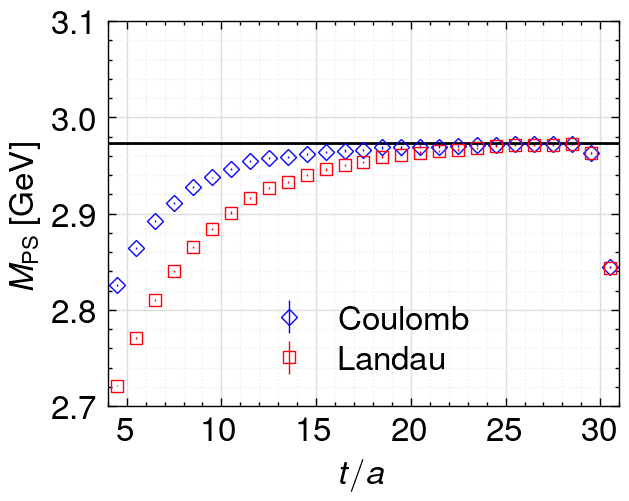

In [15]:
fig, ax = plt.subplots()

index = np.arange(0, t_size, 1)
ax.errorbar(
    index + 0.5,
    emass_c[0][:, 0] * a_invrs,
    emass_c[0][:, 1] * a_invrs,
    label="Coulomb",
    **errbar_plot_style1,
)
ax.errorbar(
    index + 0.5,
    emass_l[0][:, 0] * a_invrs,
    emass_l[0][:, 1] * a_invrs,
    label="Landau",
    **errbar_plot_style2,
)
x_fit = np.arange(0, 32, 0.01)
y_fit = np.full(x_fit.shape, 1.3666786685812669 * a_invrs)
ax.plot(
    x_fit,
    y_fit,
    linewidth=1,
    color="black",
    # label="fit",
)

# Set grid (reserved)
ax.grid(which="major", color="#DDDDDD", linewidth=0.5)
ax.grid(which="minor", color="#EEEEEE", linestyle=":", linewidth=0.5)

ax.legend(**legend_style)

ax.set_xlabel(r"$t/a$")
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.set_xlim(4, 31)

ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.set_ylabel(r"$M_{\rm PS}\ [{\rm GeV}]$")
ax.set_ylim(2.7, 3.1)

fig.savefig(f"{effmass_root}/gauge_ps_wfit(article).eps", format="eps", dpi=600)
plt.show()
plt.close()

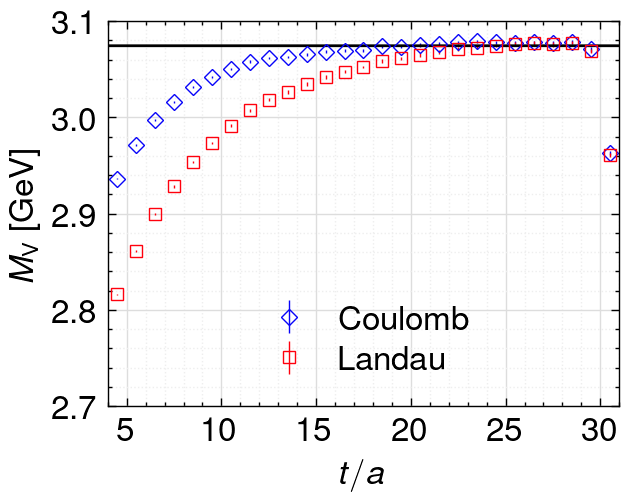

In [18]:
fig, ax = plt.subplots()

index = np.arange(0, t_size, 1)
ax.errorbar(
    index + 0.5,
    emass_c[1][:, 0] * a_invrs,
    emass_c[1][:, 1] * a_invrs,
    label="Coulomb",
    **errbar_plot_style1,
)
ax.errorbar(
    index + 0.5,
    emass_l[1][:, 0] * a_invrs,
    emass_l[1][:, 1] * a_invrs,
    label="Landau",
    **errbar_plot_style2,
)
x_fit = np.arange(0, 32, 0.01)
y_fit = np.full(x_fit.shape, 1.4133781788912954 * a_invrs)
ax.plot(
    x_fit,
    y_fit,
    linewidth=1,
    color="black",
    # label="fit",
)

# Set grid (reserved)
ax.grid(which="major", color="#DDDDDD", linewidth=0.5)
ax.grid(which="minor", color="#EEEEEE", linestyle=":", linewidth=0.5)

ax.legend(**legend_style)

ax.set_xlabel(r"$t/a$")
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.set_xlim(4, 31)

ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.set_ylabel(r"$M_{\rm V}\ [{\rm GeV}]$")
ax.set_ylim(2.7, 3.1)

fig.savefig(f"{effmass_root}/gauge_v_wfit(article).eps", format="eps", dpi=600)
plt.show()
plt.close()

## Fit the mass

In [8]:
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

fit_py = "/Users/tinikov/ccbar/fit-mqq.py"
datapath = "/Volumes/X6/data/ccbar/.archive/new/c2pt/jksamp"


def mfitQQ(tmin, tmax, ifname):
    tsize = 64
    fitsites = np.arange(tmin, tmax, 1)

    def coshFit(n, A, M):
        return A * np.cosh(M * (n - tsize / 2))

    para = {
        "A": 0.01,
        "M": 1.0,
    }

    rawdata = np.loadtxt(ifname, dtype=np.float64)[0:tsize]
    fitdata = rawdata[tmin:tmax]
    fitcorr = fitdata[:, 1]
    fiterr = fitdata[:, 2]

    # Fit
    least_squares = LeastSquares(fitsites, fitcorr, fiterr, coshFit)  # type: ignore
    m = Minuit(least_squares, **para)  # type: ignore
    m.migrad()

    # degree of freedom: (# of data) - (# of parameters) - 1
    df = tmax - tmin - 2 - 1

    return m.fval / df


resultAll = []
for tmin in range(18, 29):
    for tmax in range(36, 47):
        chisq_arr = []
        for ibin in range(bin_count):
            chisq_arr.append(
                # mfitQQ(tmin, tmax, f"{datapath}/ps/txt.2pt.ps.gfix_C.BIN{ibin+1:02}")
                mfitQQ(tmin, tmax, f"{datapath}/v/txt.2pt.v.gfix_C.BIN{ibin+1:02}")
            )
        chisq_mean = np.mean(np.array(chisq_arr))
        resultAll.append([tmin, tmax, chisq_mean])

resultAll = np.array(resultAll)
resultSort = resultAll[np.argsort(resultAll[:, 2])]
resultSort = resultSort[resultSort[:, 0] <= 26]
resultSort = resultSort[resultSort[:, 1] >= 38]
# resultSort = resultSort[resultSort[:, 0] + resultSort[:, 1] == 64]
for i in resultSort:
    print(f"{int(i[0]):02}", f"{int(i[1]):02}", i[2])

19 41 0.060616438606100505
25 42 0.06716886520602543
25 41 0.07469726109836354
24 40 0.07469726109836354
24 44 0.08546812821046798
18 41 0.09631112104481997
20 41 0.1638774140199203
24 41 0.16709313852390395
24 43 0.18828104909369536
25 43 0.21850847159406167
21 40 0.305875671934778
24 42 0.3115058022811944
22 41 0.4293464034410086
19 42 0.5327704315515897
26 39 0.549901655080065
18 42 0.5765810372747642
25 44 0.6360035794625039
24 39 0.671507132021569
26 38 0.7120995078609392
18 40 0.7674970730161811
23 41 0.7683342558252734
26 41 0.7822613168499056
20 40 0.8504270201694903
21 42 0.8631783912826185
25 45 0.9235211362926606
19 40 0.9819221309225549
25 46 1.0609142856625169
23 40 1.1375036477521592
22 42 1.550370118821859
22 43 1.7277667729293036
22 40 2.069041023133665
21 39 2.1558630327068076
23 42 2.224159708396916
18 43 2.2851124291859004
23 39 2.307167881256225
26 42 2.307167881256225
26 43 2.4348305414429974
24 46 2.5413641827247275
21 43 2.582845909600383
21 41 2.602508705488048


In [17]:
fit_py = "./fit-mqq.py"
fit_corr_path = f"{droot}/gfix_C/2pt/jksamp"

tmin = 24
tmax = 42

print("PS: ")
os.system(f"{fit_py} -t {t_size} -c {a_invrs} -r {tmin} {tmax} --ftype csh {fit_corr_path}/2pt.ps.*")

print("V: ")
os.system(f"{fit_py} -t {t_size} -c {a_invrs} -r {tmin} {tmax} --ftype csh {fit_corr_path}/2pt.v.*")


PS: 
##  Fit range: [24, 42]
##  M(LU)  = 1.3666786685812669 ± 0.0007471312838692078
##  M      = 2972.93610776483 ± 1.625234681800688
##  χ^2/df = 0.3097275221074082 ± 0.6107081771614095
V: 
##  Fit range: [24, 42]
##  M(LU)  = 1.4133781788912954 ± 0.0008925740983876382
##  M      = 3074.521552542235 ± 1.9416164362226296
##  χ^2/df = 0.3115058022811944 ± 0.32081598254836835


0